In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from IPython.display import display, Image
from src.mnist import load_data

# Load Data

In [16]:
# Load data with train and test split
X_train, X_test, y_train, y_test = load_data.load_mnist_data()

c:\Users\lukas\projects\machine_learning_examples\.venv\lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


# Binary Classifier

### Train Model

In a first step we only want to identify one digit. It will be number the digit 5. 

In [17]:
# Create target vectors
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [18]:
# Use Stochastic Gradient Descent (SGD) classifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

### Cross Validation

Let’s use the cross_val_score() function to evaluate your SGDClassifier model using K-fold cross-validation, with three folds. Remember that K-fold crossvalidation
means splitting the training set into K-folds (in this case, three), then making predictions and evaluating them on each fold using a model trained on the remaining folds

In [19]:
# Use cross validation to get the accuracy of the model
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.96545, 0.9657 , 0.96215])

### Base Estimator for Comparison

Also the Base Estimator has over 90% accuracy! This is simply because only about 10% of the images are 5s, so if you always guess that an image is not a 5, you will be right about 90% of the time.

In [20]:
# Create Base Estimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [21]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90925, 0.9113 , 0.9084 ])

### Confusion Matrix

A much better way to evaluate the performance of a classifier is to look at the confusion matrix. The general idea is to count the number of times instances of class A are classified as class B. To compute the confusion matrix, you first need to have a set of predictions, so they can be compared to the actual targets. Just like the cross_val_score() function, cross_val_predict() performs K-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold. This means that you get a clean prediction for each instance in the training set.

In [22]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [23]:
confusion_matrix(y_train_5, y_train_pred)

array([[53348,  1231],
       [  903,  4518]], dtype=int64)

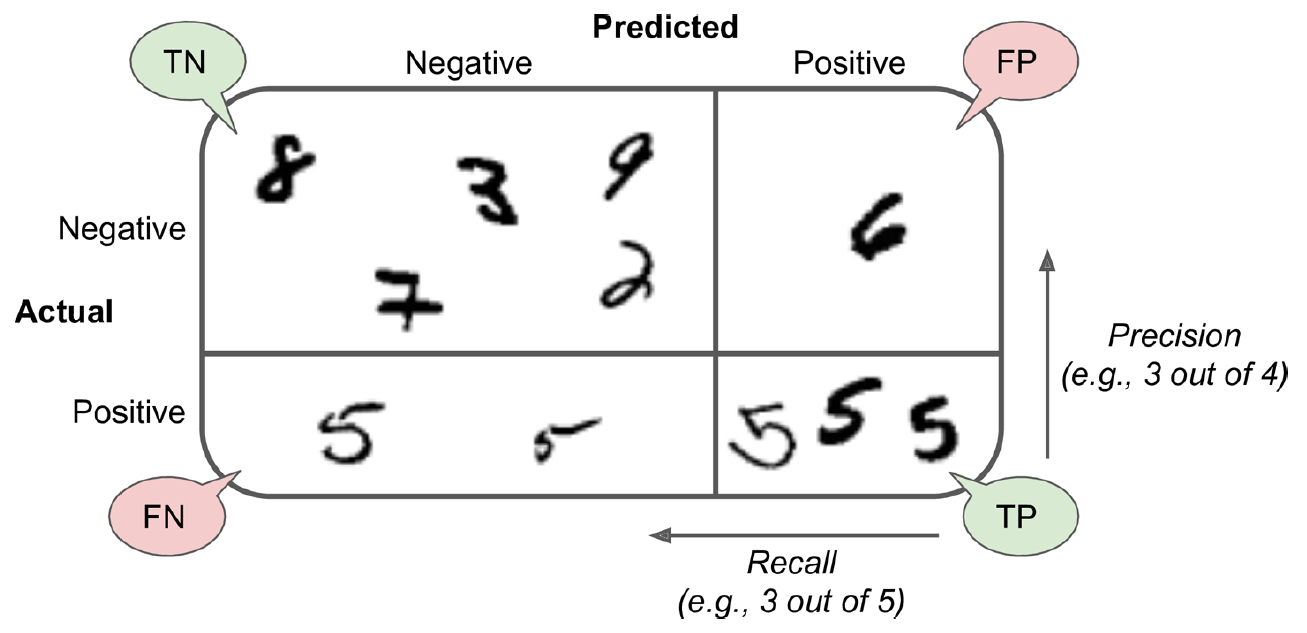

In [30]:
image_path = 'c:\\Users\\lukas\\projects\\machine_learning_examples\\figures\\confusion_matrix.png'
display(Image(filename=image_path, width=800))

**Precision=** $\frac{TP}{TP+FP}$

**Recall=** $\frac{TP}{TP+FN}$

When our classifier claims an image represents a 5, it is correct only 79% of the time. Moreover, it only detects 83% of the 5s.

In [37]:
# Precision
print("Precision:", round(precision_score(y_train_5, y_train_pred),2))
# Recall
print("Recall:", round(recall_score(y_train_5, y_train_pred),2))

Precision: 0.79
Recall: 0.83


It is often convenient to combine precision and recall into a single metric called the F1 score, in particular if you need a simple way to compare two classifiers. The F1 score is the harmonic mean of precision and recall.

In [39]:
# F1-Score
print("F1-Score:", round(f1_score(y_train_5, y_train_pred),2))

F1-Score: 0.81


### Precision/Recall Tradeoff

With the scores we can compute precision and recall for all possible thresholds using the precision_recall_curve() function

In [41]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [42]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

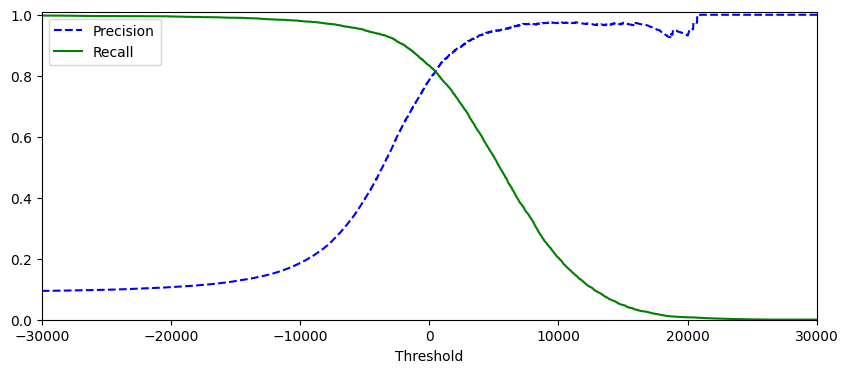

In [49]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(10, 4))
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1.01])
    plt.xlim([-30000,30000])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

### ROC Curve (Receiver Operating Characteristic)

The ROC-Curve is a graphical representation of the performance of a binary classification model. Suppose we want to classify whether a patient has cancer or not based on a blood screening. High values would indicate cancer. The question would be which value to choose as the classification threshold (at what level do we predict a disease). Let's assume we have 10 observations. If we would set the threshold to 45 we would correctly classify 4 out of 5 patients with cancer as "diseased". Subesequently one patient is misclassified. This value is called **TPR (True Positive Rate)** and is equal to sensitivity. On the other hand we misclassified two patients as "diseased" and correctly classified 3 as "healthy". These 2 out of 5 is called the **FPR (False Positive Rate)** and is 1-specificity.

**TPR = 0.8** and **FPR = 0.6**

These values (TPR and FPR) are then plotted on the ROC-Curve.

It is very similar to the precision/recall curve, but instead of plotting precision versus recall, the ROC curve plots the true positive rate (another name for recall) against the false positive rate. The FPR is the ratio of negative instances that are incorrectly classified as positive

In [51]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

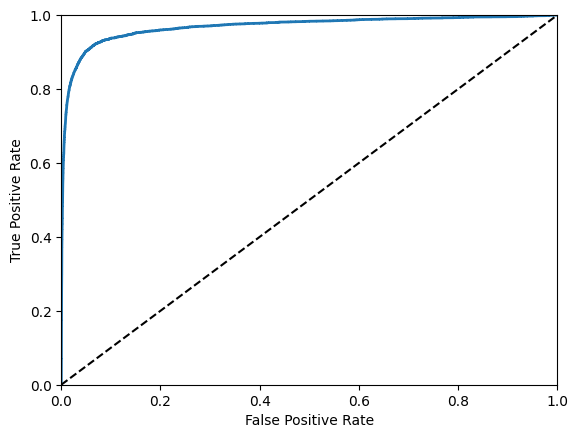

In [52]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)
plt.show()

### AUC (Area Under the Curve)

One way to compare classifiers is to measure the area under the curve (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5

In [55]:
roc_auc_score(y_train_5, y_scores)

0.968891762691813

# Random Forest Classifier

In [57]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [58]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class

In [59]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

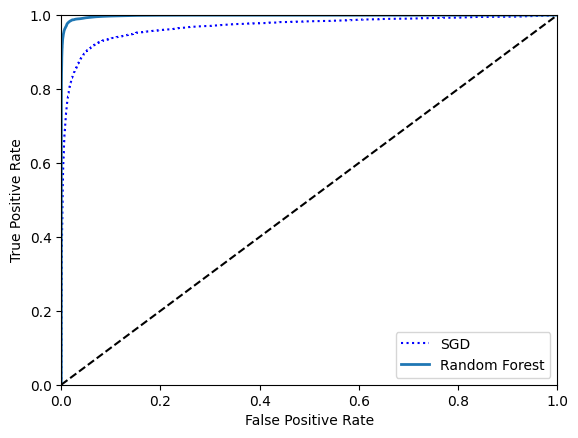

In [61]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [64]:
roc_auc_score(y_train_5, y_scores_forest)

0.9984072629680654